#### Answers to questions

* Illustrate your approach and ideas, possibly using simulated data: 
    * For shrinkage rate: Simulation of data is done by selecting a distribution to associate to every asset a duration, and we define some "true_shrinkage_rate" to have simulate the shringake event. We add some sinthethic data based on the asset called "route", thinking it as the abstraction of all the spatial possibilities of the asset. To give some tendency, we multiply by 5 the shringake possibility when the asset goes for the first route. Duration and return date are always found, think in them as expected duration and expected return date. We think the data as an end to end process, when really don't care about where is goes first or last, we have some initial data based on the asset and with that information we must predict the shrinkage rate. So we think as a classification problem, as we have to predict 0 (not lost) or 1 (lost) with a probability associted to it.
    * For pool size: We simulate only the lost data, as is the only data that affect our initial pool size. Simulating over the dates between start date and return date we increment the possibility of losing the assset by a multiplicative and incrementive factor, every days it advances, more probabilities to get lost. In addition, we multiply by that possibility to check if the model captures that non-linear feature. As we were asked the amount of assets available to IFCO at a given time, we think of the problem as a time series problem. For simplicity over calulations and show some feature engineering we tried an Elastic Net and a XGBoost regression, but take in account that in reality models like ARIMA/SARIMA with GARCH should not be descarted if stationary series are met.

* Clearly mark your assumptions and reflect on risks that may impact your model: 
    * In spite of having different possibilities on duration distribution (gamma, normal and exponential) the rest of distributions applied on the shrinkage rate (the probability of losing an asset) are done by the uniform distribution, so it generates data really difficult to learn. That's why we added some trick as simulating some noise tendency in the reality.
    * Seeming to have importance the duration, it really doesn't affect the shrinkage, as I considered is not so an asset characteristic at all. I could it include as an incrementing factor for losing probability (more duration more risk on it).

* How are shrinkage rate and pool size related? The shrinkage rate directly impacts the pool size through exponential decay like this: Pool_size(t) = Pool_size(0) × (1 - shrinkage_rate)^(t/365), thinking in a yearly context.

* Bonus: How would switching to scenario two change your approach, which limitations would be introduced? I dont think would affect more my approach because I will only introduce an observation probability similar to the losing probability. One big limitation is that it could shadow some characteristics of reality. For example, if I am unlucky and most of non observed data is from first route, I would cannot see the higher probability of losing and asset, so I should add some data validation checks to assure my data is well diversified and does not shadow key aspects. The latter being in fact, a change on my approach.


#### Instructions 

To consume the material and reproduce results, just follow this notebook having in the same folder this notebook is found, the correspoding requirements.

#### Install the requirements

In [88]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Import necessary packages

In [89]:
import numpy as np 
import plotly.express as px
import math as mth
import datetime as dt
import polars as pl
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import re
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor

#### Some variables definition

In [90]:
true_mean_trip_durations = 100
size_simulation = 10**5
shrinkage_rate = 0.1

#### Class construction for data simuation

In [ ]:
class RCPDataGenerator:
    def __init__(
            self, true_mean_duration=100, true_shrinkage_rate=0.1, 
            initial_pool_size=10**5, reference_date = dt.datetime(2025, 1, 1),
            distribution = 'normal', n_routes = 5
            ):
        self.true_mean_duration = true_mean_duration
        self.true_shrinkage_rate = true_shrinkage_rate
        self.initial_pool_size = initial_pool_size
        self.reference_date = reference_date
        self.distribution = distribution
        self.routes = ['route'+str(x+1) for x in range(n_routes+1)]
        self.trips_data = None
        self.lost_data = None
        self.pool_size_data = None

    def get_duration_on_distribution(self):
        match self.distribution:
            case 'normal':
                duration_tmp = np.random.normal(self.true_mean_duration, 0.1*self.true_mean_duration)
            case 'exponential':
                duration_tmp = np.random.exponential(self.true_mean_duration)
            case 'normal':
                duration_tmp = np.random.gamma(self.true_mean_duration*2, 1/2)
            case _:
                duration_tmp = np.random.normal(self.true_mean_duration, 0.1*self.true_mean_duration)
        return duration_tmp

        
    def generate_trips(self):
        trips = []
        asset_id = 0
        
        for _ in range(self.initial_pool_size):
            start_date = self.reference_date - dt.timedelta(days=np.random.randint(1, 365))
            duration = self.get_duration_on_distribution()
            route = random.choice(self.routes)
            is_lost = np.random.random() < self.true_shrinkage_rate * 5 if route==self.routes[0] else np.random.random() < self.true_shrinkage_rate
            
            return_date = start_date + dt.timedelta(days=duration)
            trips.append({
                'asset_id': asset_id,
                'start_date': start_date,
                'duration': duration,
                'return_date': return_date,
                'is_lost': is_lost,
                'route' : route
            })
            asset_id += 1
            
        
        self.trips_data = pl.DataFrame(trips)
        return self.trips_data
    
    def generate_simulation_lost_data(self):
        tmp_data = self.trips_data.filter(
            pl.col('is_lost')
        ).with_columns(
            pl.col('return_date').dt.truncate('1d')
        ).with_columns(
            pl.when(pl.col('is_lost')).then(pl.lit(1))
                .otherwise(pl.lit(0)).alias('is_lost')
        )

        trips_lost_simulation = []
        for row in tmp_data.iter_rows(named=True):
            start_date_selected = row['start_date']
            return_date_selected = row['return_date']
            n_days = (return_date_selected - start_date_selected).days
            date_list = [start_date_selected + dt.timedelta(days=x) for x in range(n_days+1)]
            increment = 1
            probability_l = 1/n_days
            for date_selected in date_list:
                is_lost = np.random.random() < probability_l*increment*5 if date_selected.month in [8, 12] else np.random.random() < probability_l*increment
                if is_lost:
                    trips_lost_simulation.append({
                        'date_lost': date_selected,
                        'is_lost': 1
                    })
                    break
                increment = increment + 1

        self.lost_data  = pl.DataFrame(trips_lost_simulation).group_by(
            'date_lost'
        ).agg(
            losses = pl.col('is_lost').sum()
        ).sort('date_lost').with_columns(
            pl.col("losses").cum_sum().alias("losses_cumsum")
        )

        return self.lost_data 
    
    def get_pool_size_data(self):

        starting_date = self.trips_data['start_date'].min()
        ending_date = self.trips_data['return_date'].max()
        n_days = (ending_date - starting_date).days
        date_list = [starting_date + dt.timedelta(days=x) for x in range(n_days+1)]
        self.pool_size_data = pl.DataFrame({'date' :date_list}).sort('date').with_columns(
            pool_size = pl.lit(self.initial_pool_size)
        ).join(
            self.lost_data, left_on = 'date', right_on = 'date_lost', how = 'left'
        ).with_columns(
            pl.col('losses').fill_null(0)
        ).with_columns(
            pl.col("losses").cum_sum().alias("losses_cumsum")
        ).with_columns(
            pool_size = pl.col('pool_size') - pl.col('losses_cumsum')
        ).filter(
            pl.col('date') <= self.lost_data['date_lost'].max()
        )

        return self.pool_size_data       


#### Data generation

Here we generate some data having the variables defined before. Take in account some things:
* We define a shrinkage rate of 10%, but we introduce noise by multiplying by 5 when the first route is meet.
* We suppose that duration and return date are always found in data. Think of them as the expected duration and return date.
* We define the reference date to define the start date. Understanding the start date as the date the RCP leaves
* There's multiple possibilities on the data distribution simulation, we take the normal distribution.

In [ ]:
data_generator = RCPDataGenerator(
            true_mean_duration=true_mean_trip_durations, true_shrinkage_rate=shrinkage_rate, 
            initial_pool_size=size_simulation, reference_date = dt.datetime(2025, 1, 1),
            distribution = 'normal', n_routes = 5
            )
data_1 = data_generator.generate_trips()
shrinkage_rate_aprox = data_1.filter(pl.col('is_lost')==True).shape[0]/data_1.shape[0]
print(f'Shrinkage rate aproximated is {shrinkage_rate_aprox:0.1%}')
print(f'Mean duration approxiamted is {data_1['duration'].mean():0.2f}')

Shrinkage rate aproximated is 16.4%
Mean duration approxiamted is 100.05


#### Feature engineering and modelling

In the next cells we do some feature engineering on data, modelling and prediction. At the end, we comment the results.

In [16]:
data_for_model = data_1.with_columns(
    year = pl.col('start_date').dt.year(),
    month = pl.col('start_date').dt.month()
).with_columns(
    x_1_month = (2*mth.pi*(pl.col('month')-1)/12).cos(),
    x_2_month = (2*mth.pi*(pl.col('month')-1)/12).sin()
).drop('month').to_dummies('route').drop(
    ['asset_id', 'start_date', 'return_date']
).with_columns(
    pl.when(pl.col('is_lost')).then(pl.lit(1))
        .otherwise(pl.lit(0)).alias('is_lost')
)

In [46]:
X_columns_binary = [x for x in data_for_model.columns if re.match('route', x)]
X_columns_non_binary = [x for x in data_for_model.columns if not re.match('route', x) and not re.match('is_lost', x)]

scaler = StandardScaler().fit(data_for_model.select(X_columns_non_binary))
X_train_scaled = scaler.transform(data_for_model.select(X_columns_non_binary))
X_train_scaled = np.hstack((data_for_model.select(X_columns_binary).to_numpy(), X_train_scaled))
y_train = data_for_model['is_lost'].to_numpy()

In [47]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train_scaled, y_train)

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=42, max_iter=1000, solver = 'lbfgs')
model_lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
data_generator_test = RCPDataGenerator(
            true_mean_duration=true_mean_trip_durations, true_shrinkage_rate=shrinkage_rate, 
            initial_pool_size=1000, reference_date = dt.datetime(2025, 1, 1),
            distribution = 'normal', n_routes = 5
            )
data_test = data_generator_test.generate_trips()

data_test = data_test.with_columns(
    year = pl.col('start_date').dt.year(),
    month = pl.col('start_date').dt.month()
).with_columns(
    x_1_month = (2*mth.pi*(pl.col('month')-1)/12).cos(),
    x_2_month = (2*mth.pi*(pl.col('month')-1)/12).sin()
).drop('month').to_dummies('route').drop(
    ['asset_id', 'start_date', 'return_date']
).with_columns(
    pl.when(pl.col('is_lost')).then(pl.lit(1))
        .otherwise(pl.lit(0)).alias('is_lost')
)

X_test_scaled = scaler.transform(data_test.select(X_columns_non_binary))
X_test_scaled = np.hstack((data_test.select(X_columns_binary).to_numpy(), X_test_scaled))
y_test = data_test['is_lost'].to_numpy()

In [48]:
forecast_gnb = model_gnb.predict(X_test_scaled)
probabilities_gnb =  model_gnb.predict_proba(X_test_scaled)
forecast_lr = model_lr.predict(X_test_scaled)
probabilities_lr =  model_lr.predict_proba(X_test_scaled)

acc_gnb = accuracy_score(forecast_gnb, y_test)
print(f'acuraccy for naive bayes is {acc_gnb:0.2%}')
acc_lr = accuracy_score(forecast_lr, y_test)
print(f'acuraccy for logistic regression is {acc_lr:0.2%}')


acuraccy for naive bayes is 84.00%
acuraccy for logistic regression is 83.00%


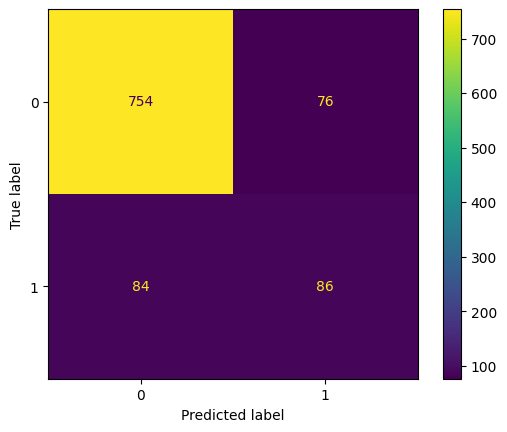

In [49]:
# confusion matrix for naive bayes
ConfusionMatrixDisplay.from_estimator(model_gnb, X_test_scaled, y_test)

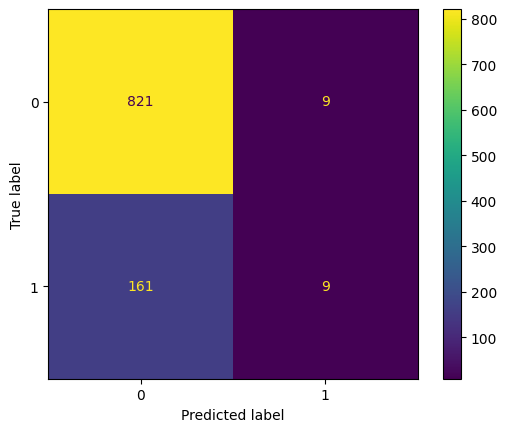

In [50]:
# confusion matrix for logisticregression
ConfusionMatrixDisplay.from_estimator(model_lr, X_test_scaled, y_test)

#### Comment on shrinkage rate result of modelling

Let's comment some points:
* Accuracy is similiar in both models, even naive bayes is slightly higher.
* Seeing the confusion matrix we can see that logistic regression has a lot of false negatives (comparing to false positives), even thought it has more true negatives. In fact, there are a lot of negatives predictions.
* Considering that in our case if there are the same false positives and false negatives, they compensate each other (what we expected not to lose we lose, and what we expected to lose we lose). Naive Bayes seems the model to choose for now.


#### Data generation for pool size

In this case, as commented before, we will thought the model taking in account just time variables. So we will consider data generated for a year, and predicting the next year (as we started again with the same number) and see if the models learns in an acceptable way. At the end, we comment the results.

In [23]:
lost_data = data_generator.generate_simulation_lost_data()
pool_size_data = data_generator.get_pool_size_data()

In [24]:
fig = px.line(pool_size_data, x="date", y="pool_size", title='pool_size_over_time')
fig.show()

In [ ]:
X_train = pool_size_data.filter(
    (pl.col('date') >= dt.datetime(2024, 1, 1)) &
    (pl.col('date') < dt.datetime(2025, 1, 1))
).with_columns(
    year = pl.col('date').dt.year(),
    month = pl.col('date').dt.month(),
    day = pl.col('date').dt.day(),
    weekday = pl.col('date').dt.weekday(),
    week = pl.col('date').dt.week()
).with_columns(
    x_1_month = (2*mth.pi*(pl.col('month')-1)/12).cos(),
    x_2_month = (2*mth.pi*(pl.col('month')-1)/12).sin(),
    x_1_weekday = (2*mth.pi*(pl.col('weekday')-1)/7).cos(),
    x_2_weekday = (2*mth.pi*(pl.col('weekday')-1)/7).sin(),
    x_1_week = (2*mth.pi*(pl.col('week')-1)/53).cos(),
    x_2_week = (2*mth.pi*(pl.col('week')-1)/53).sin()
).drop(['month', 'weekday', 'week', 'losses', 'losses_cumsum', 'date', 'pool_size'])
y_train = pool_size_data.filter(
    (pl.col('date') >= dt.datetime(2024, 1, 1)) &
    (pl.col('date') < dt.datetime(2025, 1, 1))
)['pool_size']

In [110]:
model_linear = ElasticNet(random_state = 42).fit(X_train, y_train)
model_xgb = XGBRegressor(random_state = 42).fit(X_train, y_train)

In [111]:
start_date = dt.datetime(2025, 1, 1)
end_date = dt.datetime(2025, 12, 31)
n_days = (end_date - start_date).days
date_list = [start_date + dt.timedelta(days=x) for x in range(n_days+1)]

In [ ]:
X_test = pl.DataFrame({'date':date_list}).with_columns(
    year = pl.col('date').dt.year(),
    month = pl.col('date').dt.month(),
    day = pl.col('date').dt.day(),
    weekday = pl.col('date').dt.weekday(),
    week = pl.col('date').dt.week()
).with_columns(
    x_1_month = (2*mth.pi*(pl.col('month')-1)/12).cos(),
    x_2_month = (2*mth.pi*(pl.col('month')-1)/12).sin(),
    x_1_weekday = (2*mth.pi*(pl.col('weekday')-1)/7).cos(),
    x_2_weekday = (2*mth.pi*(pl.col('weekday')-1)/7).sin(),
    x_1_week = (2*mth.pi*(pl.col('week')-1)/53).cos(),
    x_2_week = (2*mth.pi*(pl.col('week')-1)/53).sin()
).drop(['date', 'month', 'weekday', 'week'])

In [113]:
forecast_linear = model_linear.predict(X_test)
forecast_xgb = model_xgb.predict(X_test)

In [114]:
fig = px.line(x=date_list, y=forecast_linear, title='pool_size_over_time')
fig.show()

In [115]:
fig = px.line(x=date_list, y=forecast_xgb, title='pool_size_over_time')
fig.show()

#### Comment on pool size result of modelling

Let's comment some points:
* ElasticNet really bad, possible due to the lack of data and no machine learning tools to learn.
* Despite it add some noise at the beginning, XGBoost regression takes in account the deeper steps of losing RCP's at august and december, so it learned well.